# todo list
- >>> redo the tables: rethink the whole dataset as parquet files that can have category types. If there are a lot of missing values, turn into separate table.
- >>> use efficient int and float types by first using .convert_dtypes() to look for best type.

- what is faster? list to columns to stacked column (the expand technique) or explode technique?
- not sure if all the copy's are needed
- set dtypes (convert text to string)
- nconst and tconst must be converted to categories
- optimize
- check todo's
- we are going with parquet. sql can be used later.


In [1]:
import os
import re
import sys
import time
import gzip
import shutil
import requests
import numpy as np
import pandas as pd
from datetime import date

START_TIME = time.time()

BASE_URL = "https://datasets.imdbws.com/"

FILES_IMDB = {
    "tit_bas": "title.basics.tsv",
    "tit_rate": "title.ratings.tsv",
    "name_bas": "name.basics.tsv",
    "tit_prin": "title.principals.tsv",
    "cast_crew": "title.crew.tsv",
}

FILES_IMDB_PARQ = {
    "ordering" : "ordering.parquet",
    "ordering_categories" : "ordering_categories.parquet",
    "category" : "category.parquet",
    "ordering_jobs" : "ordering_jobs.parquet",
    "job" : "job.parquet",
    "ordering_character" : "ordering_character.parquet",
    "character" : "character.parquet",
}

FILES_HAND = {
    "add_seen": "add_movies_seen.txt",
    "add_unseen": "add_movies_unseen.txt",
    "add_secop": "add_movies_second_opinion.txt",
    "raw_status": "raw_status.xlsx"
}

FILES_GENERATED = {
    "films_raw": "films_raw.pkl",
    "films_reading": "films_reading.xlsx"
}

# lets look af the missing values to determine what tables must be made

## title basics

In [2]:
title_basics_path = os.path.join("data/imdb/",FILES_IMDB['tit_bas'])
title_basics = pd.read_csv(title_basics_path,sep='\t', quotechar='\t', low_memory=False)
title_basics = title_basics.replace(to_replace = "\\N", value = np.nan)

<AxesSubplot:>

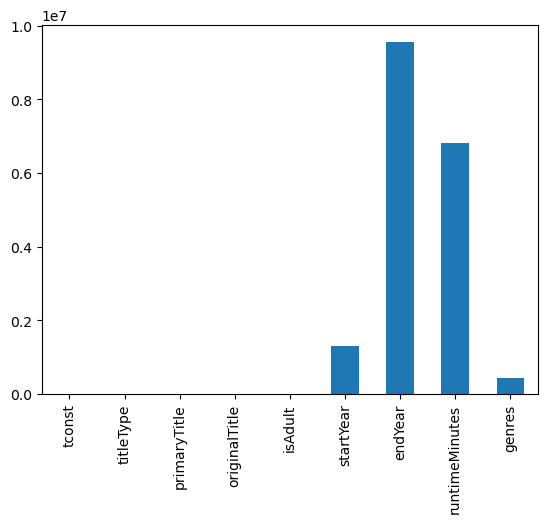

In [11]:
title_basics.isna().sum().plot.bar()

## name basics

In [12]:
name_bas_path = os.path.join("data/imdb/",FILES_IMDB['name_bas'])
name_bas = pd.read_csv(name_bas_path,sep='\t', low_memory=True)
name_bas = name_bas.replace(to_replace = "\\N", value = np.nan)

<AxesSubplot:>

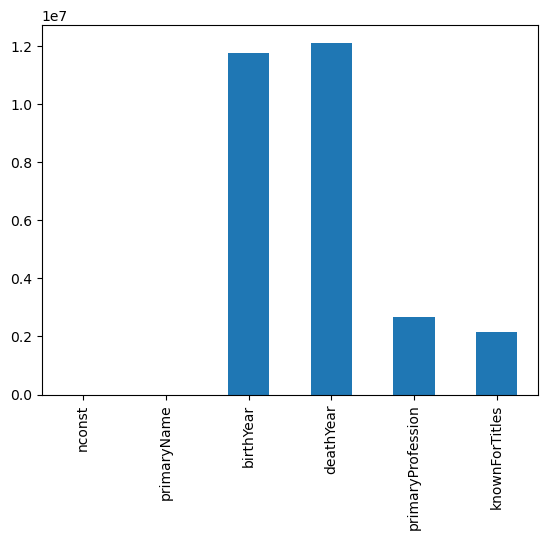

In [13]:
name_bas.isna().sum().plot.bar()

# functions

In [2]:
def setTNconst(df, key, set_index, drop_col):
    # tconst
    # We remove the first two tt and convert it to int.
    # Commands are not chained, baecause this can cause memory issues with big files.
    df.loc[:,key] = df.loc[:,key].str.slice(2)
    df.loc[:,key] = df.loc[:,key].astype('Int64')
    df.loc[:,key] = df.loc[:,key].astype('category')
    if set_index:
        df = df.set_index(key, drop=drop_col)
    return df


def toCategories(data, key):
    # getting ready to convert to numbers
    data.loc[:,key] = data.loc[:,key].astype('category')
    cat_converter = data.loc[:,key].factorize()
    nummerized = cat_converter[0]
    converter = cat_converter[1].codes
    cats = cat_converter[1].categories

    # convert cats in link table to numbers
    data.loc[:,key] = nummerized
    data.loc[:,key] = data.loc[:,key].astype('category')

    # create cat table
    cats = pd.DataFrame({key: [ cats[converter[x]] for x in range(len(converter))]})
    cats.loc[:,key] = cats.loc[:,key].astype('category')
    cats.index.name = "index"

    return data, cats


def ExplodeNameIdColumn(data):
    # turn this into an table on it's own
    data = data.str.replace("nm","")
    data = data.str.split(',')
    data = data.loc[~data.isna()].explode().astype("Int64").copy()
    data = data.astype('category')
    return  data.to_frame()

# convert title.basics (dtypes are good)

In [3]:
def cleanTitlesBasic(tit_bas):
    tit_bas = setTNconst(tit_bas, 'tconst', set_index=True, drop_col=True)

    # isAdult
    # Those movies are checked, and were not adult movies.
    # movies that are not an 1 or '1' aren't adult movies
    tit_bas.loc[:,"isAdult"] = tit_bas.loc[:,"isAdult"].fillna(0).astype('str')
    tit_bas.loc[tit_bas.loc[:,'isAdult'] != '1', 'isAdult'] = '0'
    tit_bas.loc[:,"isAdult"] = tit_bas.loc[:,"isAdult"].map({'1': True, '0': False})

    # auto convert
    tit_bas = tit_bas.convert_dtypes()

    # titleType
    # There are a few null values (np.nan)
    # convert to category
    tit_bas.loc[:,"titleType"] = tit_bas.loc[:,"titleType"].astype('category')

    # startYear & endYear & runtimeMinutes
    # both contain a lot of np.nan
    tit_bas.loc[:,["startYear","endYear","runtimeMinutes"]] = tit_bas.loc[:,["startYear","endYear","runtimeMinutes"]].astype('Int64')

    return tit_bas

In [4]:
def createGenreTables(title_basics):
    genres_raw = title_basics.loc[:,'genres'].copy()
    title_basics = title_basics.drop(columns='genres')
    genres_raw = genres_raw.str.split(",", expand=True)

    # create link table 
    title_basics_genres = (genres_raw
        .stack()
        .reset_index()
        .rename(columns={"level_0":'tconst', 0:"genre"})
        .set_index("tconst")
        .drop(columns='level_1'))
    # title_basics_genres.loc[:,'genre'] = title_basics_genres.loc[:,'genre'].astype('category')

    title_basics_genres, genres = toCategories(title_basics_genres, 'genre')

    return title_basics, title_basics_genres, genres

originele code hierboven duurt 2m 41s

In [5]:
title_basics_path = os.path.join("data/imdb/",FILES_IMDB['tit_bas'])
title_basics = pd.read_csv(title_basics_path,sep='\t', quotechar='\t', low_memory=False)
title_basics = title_basics.replace(to_replace = "\\N", value = np.nan)

title_basics = cleanTitlesBasic(title_basics)
genres_raw = title_basics.genres.str.split(",", expand=True)
title_basics = title_basics.drop(columns='genres')

# convert to category
title_basics['titleType'] = title_basics['titleType'].astype('category')

# create link table 
title_basics_genres = (genres_raw
    .stack()
    .reset_index()
    .rename(columns={"level_0":'tconst', 0:"genre"})
    .set_index("tconst")
    .drop(columns='level_1'))

# convert to category
title_basics_genres['genre'] = title_basics_genres['genre'].astype('category')

# make seperate tables
tb_genre = title_basics_genres['genre'].cat.codes.to_frame()
tb_genre = tb_genre.rename(columns={0:"genre"})
genre = pd.DataFrame(title_basics_genres['genre'].cat.categories.to_list()).rename(columns={0:"genre"})

In [39]:
title_basics

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes
tconst,,,,,,,
1,1,Carmencita,Carmencita,False,1894,<NA>,1
2,1,Le clown et ses chiens,Le clown et ses chiens,False,1892,<NA>,5
3,1,Pauvre Pierrot,Pauvre Pierrot,False,1892,<NA>,4
4,1,Un bon bock,Un bon bock,False,1892,<NA>,12
5,1,Blacksmith Scene,Blacksmith Scene,False,1893,<NA>,1
...,...,...,...,...,...,...,...
9916848,2,Episode #3.17,Episode #3.17,False,2010,<NA>,<NA>
9916850,2,Episode #3.19,Episode #3.19,False,2010,<NA>,<NA>
9916852,2,Episode #3.20,Episode #3.20,False,2010,<NA>,<NA>


bovenste code afmaken en uittesten

In [25]:
title_basics

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
tconst,,,,,,,,
1,short,Carmencita,Carmencita,False,1894,<NA>,1,"Documentary,Short"
2,short,Le clown et ses chiens,Le clown et ses chiens,False,1892,<NA>,5,"Animation,Short"
3,short,Pauvre Pierrot,Pauvre Pierrot,False,1892,<NA>,4,"Animation,Comedy,Romance"
4,short,Un bon bock,Un bon bock,False,1892,<NA>,12,"Animation,Short"
5,short,Blacksmith Scene,Blacksmith Scene,False,1893,<NA>,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...
9916848,tvEpisode,Episode #3.17,Episode #3.17,False,2010,<NA>,<NA>,"Action,Drama,Family"
9916850,tvEpisode,Episode #3.19,Episode #3.19,False,2010,<NA>,<NA>,"Action,Drama,Family"
9916852,tvEpisode,Episode #3.20,Episode #3.20,False,2010,<NA>,<NA>,"Action,Drama,Family"


,0,1,2
tconst,,,
1,Documentary,Short,<NA>
2,Animation,Short,<NA>
3,Animation,Comedy,Romance
4,Animation,Short,<NA>
5,Comedy,Short,<NA>
...,...,...,...
9916848,Action,Drama,Family
9916850,Action,Drama,Family
9916852,Action,Drama,Family


# convert title rate (dtypes are good)

In [29]:
def convertTitleRate(title_rate):
    title_rate = setTNconst(title_rate, 'tconst', set_index=True, drop_col=True)

    # convert averageRating
    title_rate.loc[:,'averageRating'] = title_rate.loc[:,'averageRating'].astype('float')

    # convert numVotes
    title_rate.loc[:,'numVotes'] = title_rate.loc[:,'numVotes'].astype('int')

    return title_rate

In [30]:
title_rate_path = os.path.join("data/imdb/",FILES_IMDB['tit_rate'])
title_rate = pd.read_csv(title_rate_path,sep='\t', quotechar='\t', low_memory=False)
title_rate = title_rate.replace(to_replace = "\\N", value = np.nan)

title_rate = convertTitleRate(title_rate)

# convert title.crew (dtypes zijn goed)

In [37]:
def convertDirectorsAndWriters(title_crew):
    title_crew = setTNconst(title_crew, 'tconst', set_index=True, drop_col=True)

    # directors
    directors = ExplodeNameIdColumn(title_crew.loc[:,'directors'].copy())
    writers = ExplodeNameIdColumn(title_crew.loc[:,'writers'].copy())
    
    return directors, writers

In [41]:
title_crew_path = os.path.join("data/imdb/",FILES_IMDB['cast_crew'])
title_crew = pd.read_csv(title_crew_path,sep='\t', quotechar='\t', low_memory=True)
title_crew = title_crew.replace(to_replace = "\\N", value = np.nan)

directors, writers = convertDirectorsAndWriters(title_crew)

# convert name basics

In [3]:
def createNameBasicsTables(name_bas):
    name_bas = setTNconst(name_bas, 'nconst', set_index=True, drop_col=True)

    # primaryName
    ## Some names have quotes, and some names are missing.
    ## We don't have to modify them.

    # birthYear & deathYear has a lot of missing values
    # some are year 4, or 12. those are greek writers like nm0653992 (Ovid) 
    # which play was used for the movie.
    name_bas.loc[:,"birthYear"] = name_bas.loc[:,"birthYear"].astype('Int64')
    name_bas.loc[:,"deathYear"] = name_bas.loc[:,"deathYear"].astype('Int64')

    # knownForTitles
    # turn this into an table on it's own
    knownfor = name_bas.loc[:,"knownForTitles"].copy()
    name_bas = name_bas.drop(columns="knownForTitles")
    knownfor = knownfor.str.replace("tt","")
    knownfor = knownfor.str.split(',')
    knownfor = knownfor.loc[~knownfor.isna()].explode().astype("Int64").copy()

    prim_prof_raw = name_bas.loc[:,"primaryProfession"].copy()
    name_bas = name_bas.drop(columns="primaryProfession")
    prim_prof_raw = prim_prof_raw.str.replace("nm","")
    prim_prof_raw = prim_prof_raw.str.split(",", expand=True)

    # create link table
    name_bas_prim_prof = (prim_prof_raw
        .stack()
        .reset_index()
        .rename(columns={"level_0":'nconst', 0:"profession"})
        .set_index("nconst")
        .drop(columns='level_1'))
    name_bas_prim_prof.loc[:,'profession'] = name_bas_prim_prof.loc[:,'profession'].astype('category')

    name_bas_prim_prof, professions = toCategories(name_bas_prim_prof, 'profession')

    return name_bas, name_bas_prim_prof, professions, knownfor

In [4]:
name_bas_path = os.path.join("data/imdb/",FILES_IMDB['name_bas'])
name_bas = pd.read_csv(name_bas_path,sep='\t', low_memory=True)
name_bas = name_bas.replace(to_replace = "\\N", value = np.nan)

name_bas, name_bas_prim_prof, professions, knownfor = createNameBasicsTables(name_bas)

# convert title.principals

In [3]:
def createOrderingFile():
    # loading file
    tit_prin_path = os.path.join("data/imdb/", FILES_IMDB['tit_prin'])
    ordering = pd.read_csv(tit_prin_path,sep='\t', low_memory=True)
    ordering = ordering.drop(columns=['characters', 'category', 'job'])

    # converting
    ordering = ordering.replace(to_replace = "\\N", value = np.nan)
    ordering = setTNconst(ordering, 'tconst', set_index=False, drop_col=False)
    ordering = setTNconst(ordering, 'nconst', set_index=False, drop_col=False)

    # set index
    ordering = ordering.set_index(['tconst', 'nconst'], drop=True)
    ordering.loc[:,"ordering"] = ordering.loc[:,"ordering"].astype('Int8')

    parq_path = "data/imdb/parquet/"
    path = os.path.join(parq_path, FILES_IMDB_PARQ['ordering'])
    ordering.to_parquet(path, engine='pyarrow')

In [47]:
def createCategoriesFiles():
    # loading file
    tit_prin_path = os.path.join("data/imdb/", FILES_IMDB['tit_prin'])
    categories = pd.read_csv(tit_prin_path,sep='\t', low_memory=True)
    categories = categories.drop(columns=['characters', 'ordering', 'job'])

    # converting
    categories = categories.replace(to_replace = "\\N", value = np.nan)
    categories = setTNconst(categories, 'tconst', set_index=False, drop_col=False)
    categories = setTNconst(categories, 'nconst', set_index=False, drop_col=False)

    # set index
    categories = categories.set_index(['tconst', 'nconst'], drop=True)

    # convert to category
    categories['category'] = categories['category'].astype('category')

    # make seperate tables
    principals_categories = categories['category'].cat.codes.to_frame()
    principals_categories = principals_categories.rename(columns={0:"category"})
    categories = pd.DataFrame(categories['category'].cat.categories.to_list()).rename(columns={0:"category"})

    parq_path = "data/imdb/parquet/"
    path = os.path.join(parq_path, FILES_IMDB_PARQ['ordering_category'])
    principals_categories.to_parquet(path, engine='pyarrow')
    path = os.path.join(parq_path, FILES_IMDB_PARQ['category'])
    categories.to_parquet(path, engine='pyarrow')

    # how to join
    # pd.merge(principals_categories,real_categories, how='left', left_on='category', right_index=True)

category_x       category_y
tconst  nconst                               
1       1588970           10             self
        5690               6         director
        374658             4  cinematographer
2       721526             6         director
        1335271            5         composer
...                      ...              ...
9916880 10535738           1          actress
        996406             6         director
        1482639           11           writer
        2586970           11           writer
        1594058            8         producer

[54928270 rows x 2 columns]

In [ ]:
def createJobFiles():
    # loading file
    tit_prin_path = os.path.join("data/imdb/", FILES_IMDB['tit_prin'])
    jobs = pd.read_csv(tit_prin_path,sep='\t', low_memory=True)
    jobs = jobs.drop(columns=['characters', 'ordering', 'category'])

    # converting
    jobs = jobs.replace(to_replace = "\\N", value = np.nan)
    jobs = setTNconst(jobs, 'tconst', set_index=False, drop_col=False)
    jobs = setTNconst(jobs, 'nconst', set_index=False, drop_col=False)

    # set index
    jobs = jobs.set_index(['tconst', 'nconst'], drop=True)

    # drop nan's
    jobs = jobs.dropna()

    # convert to category
    jobs['job'] = jobs['job'].astype('category')

    # make seperate tables
    ordering_jobs = jobs['job'].cat.codes.to_frame()
    ordering_jobs = ordering_jobs.rename(columns={0:"job"})
    jobs = pd.DataFrame(jobs['job'].cat.categories.to_list()).rename(columns={0:"job"})

    # save to disc
    parq_path = "data/imdb/parquet/"
    path = os.path.join(parq_path, FILES_IMDB_PARQ['ordering_jobs'])
    ordering_jobs.to_parquet(path, engine='pyarrow')
    path = os.path.join(parq_path, FILES_IMDB_PARQ['job'])
    jobs.to_parquet(path, engine='pyarrow')

In [ ]:
def createCharacterFiles():
    # loading file
    tit_prin_path = os.path.join("data/imdb/", FILES_IMDB['tit_prin'])
    characters = pd.read_csv(tit_prin_path,sep='\t', low_memory=True)
    characters = characters.drop(columns=['category', 'job', 'ordering'])

    # converting
    characters = setTNconst(characters, 'tconst', set_index=False, drop_col=False)
    characters = setTNconst(characters, 'nconst', set_index=False, drop_col=False)
    characters['characters'] = characters['characters'].astype('string')
    characters = characters.replace(to_replace = "\\N", value = np.nan)

    # drop na's
    characters = characters.dropna()

    # set index
    characters = characters.set_index(['tconst', 'nconst'], drop=True)

    # turn string into list
    characters['characters'] = characters['characters'].apply(eval)
    
    # unpack lists
    characters = characters.explode('characters')
    
    # convert to category
    characters['characters'] = characters['characters'].astype('category')

    # make seperate tables
    ordering_character = characters['characters'].cat.codes.to_frame()
    ordering_character = ordering_character.rename(columns={0:"character"})
    character = pd.DataFrame(characters['characters'].cat.categories.to_list()).rename(columns={0:"character"})

    # save to disc
    parq_path = "data/imdb/parquet/"
    path = os.path.join(parq_path, FILES_IMDB_PARQ['ordering_character'])
    ordering_character.to_parquet(path, engine='pyarrow')
    path = os.path.join(parq_path, FILES_IMDB_PARQ['character'])
    character.to_parquet(path, engine='pyarrow')

executing all code

In [4]:
createOrderingFile()
createCategoriesFiles()
createJobFiles()
createCharacterFiles()

everything below here is old

In [6]:
def makeLinkTableAndCatTable(single_attribute_df):
    # universal function for category, characters and job
    # takes in dataframe with 1 key

    # remove null values
    key = list(single_attribute_df.columns.values)[0]
    has_category = ~single_attribute_df[key].isna()
    single_attribute_df = single_attribute_df[has_category].copy()
    single_attribute_df.loc[:,key] = single_attribute_df.loc[:,key].astype('category')

    single_attribute_df, categories = toCategories(single_attribute_df, key)
    
    categories.loc[:,key] = categories.loc[:,key].astype('category')

    return single_attribute_df, categories

In [23]:
real_categories

,0
0,actor
1,actress
2,archive_footage
3,archive_sound
4,cinematographer
5,composer
6,director
7,editor
8,producer
9,production_designer


In [ ]:
pd.merge()

In [15]:
categories.category.values.categories

Index(['actor', 'actress', 'archive_footage', 'archive_sound',
       'cinematographer', 'composer', 'director', 'editor', 'producer',
       'production_designer', 'self', 'writer'],
      dtype='object')

In [20]:
categories['category'].astype('int')

ValueError: Cannot cast object dtype to int64

In [ ]:
categories_link = categories.loc[:,"category"].to_frame()
del categories

In [12]:
categories_link

,category
0,0
1,1
2,2
3,1
4,3
...,...
54928265,7
54928266,1
54928267,8
54928268,8


In [12]:

del ordering

old code:

In [4]:
def prepareTitlePrin(tit_prin):
    tit_prin = setTNconst(tit_prin, 'tconst', set_index=False, drop_col=False)
    tit_prin = setTNconst(tit_prin, 'nconst', set_index=False, drop_col=False)

    # set index
    tit_prin = tit_prin.set_index(['tconst', 'nconst'], drop=True)

    return tit_prin


def makeCharacters(tit_prin):
    # prepare data
    characters_link = tit_prin.loc[:,"characters"].to_frame()
    characters_link.loc[:,'characters'] = tit_prin.loc[:,'characters'].str.replace("\",\"","@").replace(r'[\[\]\"]',"", regex=True)
    characters_link.loc[:,'characters'] = tit_prin.loc[:,'characters'].str.split('@')
    characters_link = characters_link.explode('characters')
    characters_link, characters_category = makeLinkTableAndCatTable(characters_link)
    tit_prin = tit_prin.drop("characters", axis=1)
    
    return tit_prin, characters_link, characters_category


def makeCategories(tit_prin):
    categories_link = tit_prin.loc[:,"category"].to_frame()
    categories_link, categories_category = makeLinkTableAndCatTable(categories_link)
    tit_prin = tit_prin.drop("category", axis=1)
    
    return tit_prin, categories_link, categories_category


def makeJobs(tit_prin):
    jobs_link = tit_prin.loc[:,"job"].to_frame()
    jobs_link, jobs_category = makeLinkTableAndCatTable(jobs_link)
    tit_prin = tit_prin.drop("job", axis=1)
    
    return tit_prin, jobs_link, jobs_category



def makeTitlePrinTables(tit_prin):
    # prepare data
    characters_link = tit_prin.loc[:,"characters"].to_frame()
    characters_link.loc[:,'characters'] = tit_prin.loc[:,'characters'].str.replace("\",\"","@").replace(r'[\[\]\"]',"", regex=True)
    characters_link.loc[:,'characters'] = tit_prin.loc[:,'characters'].str.split('@')
    characters_link = characters_link.explode('characters')
    characters_link, characters_category = makeLinkTableAndCatTable(characters_link)
    # write to disk
    # >>> still needed to be made
    del characters_link
    del characters_category

    categories_link = tit_prin.loc[:,"category"].to_frame()
    categories_link, categories_category = makeLinkTableAndCatTable(categories_link)
    # write to disk
    # >>> still needed to be made
    del categories_link
    del categories_category

    
    jobs_link = tit_prin.loc[:,"job"].to_frame()
    jobs_link, jobs_category = makeLinkTableAndCatTable(jobs_link)
    # write to disk
    # >>> still needed to be made
    del jobs_link
    del jobs_category

In [5]:
tit_prin_path = os.path.join("data/imdb/", FILES_IMDB['tit_prin'])
tit_prin = pd.read_csv(tit_prin_path,sep='\t', low_memory=True)
tit_prin = tit_prin.replace(to_replace = "\\N", value = np.nan)

In [6]:
tit_prin = prepareTitlePrin(tit_prin)

In [7]:
parq_path = "data/imdb/parquet/"

In [8]:
tit_prin, characters_link, characters_category = makeCharacters(tit_prin)
path = os.path.join(parq_path, FILES_IMDB_PARQ['characters_link'])
characters_link.to_parquet(path, engine='pyarrow')
del characters_link
path = os.path.join(parq_path, FILES_IMDB_PARQ['characters_category'])
characters_category.to_parquet(path, engine='pyarrow')
del characters_category

The kernel crashes on the next cell. it uses too much memory.

In [9]:
tit_prin, categories_link, categories_category = makeCategories(tit_prin)
path = os.path.join(parq_path, FILES_IMDB_PARQ['categories_link'])
categories_link.to_parquet(path, engine='pyarrow')
del categories_link
path = os.path.join(parq_path, FILES_IMDB_PARQ['categories_category'])
categories_category.to_parquet(path, engine='pyarrow')
del categories_category

: 

: 

In [ ]:
tit_prin, jobs_link, jobs_category = makeJobs(tit_prin)
path = os.path.join(parq_path, FILES_IMDB_PARQ['jobs_link'])
jobs_link.to_parquet(path, engine='pyarrow')
del jobs_link
path = os.path.join(parq_path, FILES_IMDB_PARQ['jobs_category'])
jobs_category.to_parquet(path, engine='pyarrow')
del jobs_category



# makeTitlePrinTables(tit_prin)

# # remove columns
# tit_prin = tit_prin.drop(columns=['characters','category','job'])